## Worksheet 3

### Group 22 Eaton Heidegger and Shannon Schröder

### 1. Convergence Order of ODE integration schemes

#### 1.1 Implementation of different Methods

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
# ODE
def f(x, y):
    return (1- y) * y

In [4]:
# Derivative of f
def df(x, y):
    return 1 - 2 * y

In [5]:
# Exact solution
def exact_solution(x, y0):
    return 1 / (1 + ((1 - y0) / y0) * np.exp(-x))

In [6]:
# Forward Euler method
def forward_euler(f, x, y, h):
    return y + h * f(x, y)

Simple method that is only first order accurate $O(h)$, meaning it gets more accurate as $h$ decreases, but not very fast. It is an explicit method, simple to use but can become unstable for higher $h$.

In [7]:
# Backward Euler method
def backward_euler(f, df, x, y, h, eps=1e-4):
    xp = x + h
    yp = y

    while True:
        ypnext = yp - (yp - y - h * f(xp, yp)) / (1 - h * df(xp, yp))
        if np.abs(ypnext - yp) < eps:
            break
        yp = ypnext
    return ypnext

Implicit method, requiring iterative Newton's method to solve. It is more stable than the forward Euler method, but is also only first order accurate $O(h)$.

In [8]:
# Crank-Nicolson method
def crank_nicolson(f, df, x, y, h, eps=1e-4):
    xp = x + h
    yp = y

    while True:
        ypnext = yp - (yp - y - h/2 * (f(xp, yp) + f(x, y))) / (1 - h/2 * df(xp, yp))
        if np.abs(ypnext - yp) < eps:
            break
        yp = ypnext
    return ypnext

Second-order accurate $O(h^2)$, meaning it converges to the true solution faster than Euler methods. Uses average slope instead of just forward differences.

In [9]:
# Heun's Runge-Kutta 2nd order method
def rk2(f, x, y, h):
    k1 = f(x, y)
    k2 = f(x + h, y + h * k1)
    return y + h/2 * (k1 + k2)

Uses two slopes ($k1$ and $k2$) to estimate the next value. Second-order accurate $O(h^2)$.

In [10]:
# Runge-Kutta 4th order method
def rk4(f, x, y, h):
    k1 = f(x, y)
    k2 = f(x + h/2, y + h/2 * k1)
    k3 = f(x + h/2, y + h/2 * k2)
    k4 = f(x + h, y + h * k3)
    return y + h/6 * (k1 + 2*k2 + 2*k3 + k4)

Fourth order accurate $O(h^4)$, meaning errors decrease much faster than other methods. Most accurate of the methods implemented.

In [11]:
# Main function to solve the ODE using different methods
def solve_ode(method, f, df, x0, y0, h, x_end):
    x_values = np.arange(x0, x_end + h, h)
    y_values = np.zeros_like(x_values)
    y_values[0] = y0

    for i in range(1, len(x_values)):
        x, y = x_values[i - 1], y_values[i - 1]
        if method == "forward_euler":
            y_values[i] = forward_euler(f, x, y, h)
        elif method == "backward_euler":
            y_values[i] = backward_euler(f, df, x, y, h)
        elif method == "crank_nicolson":
            y_values[i] = crank_nicolson(f, df, x, y, h)
        elif method == "rk2":
            y_values[i] = rk2(f, x, y, h)
        elif method == "rk4":
            y_values[i] = rk4(f, x, y, h)
    
    return x_values, y_values

Here, we iterate over time steps to compute $y(x)$, storing the results in y_values. The method used depends on the input, allowing us to compare different numerical approaches.

In [12]:
# Parameters
x0 = 0
y0 = 0.1
h = 0.1
x_end = 4

In [13]:
# Solve the ODE using different methods
methods = ["forward_euler", "backward_euler", "crank_nicolson", "rk2", "rk4"]
solutions = {method: solve_ode(method, lambda x, y: y - y**2, lambda x, y: 1 - 2*y, x0, y0, h, x_end) for method in methods}

Each method is defined separately and then used within the ODE solver, which runs the solver for each method and stores the results.

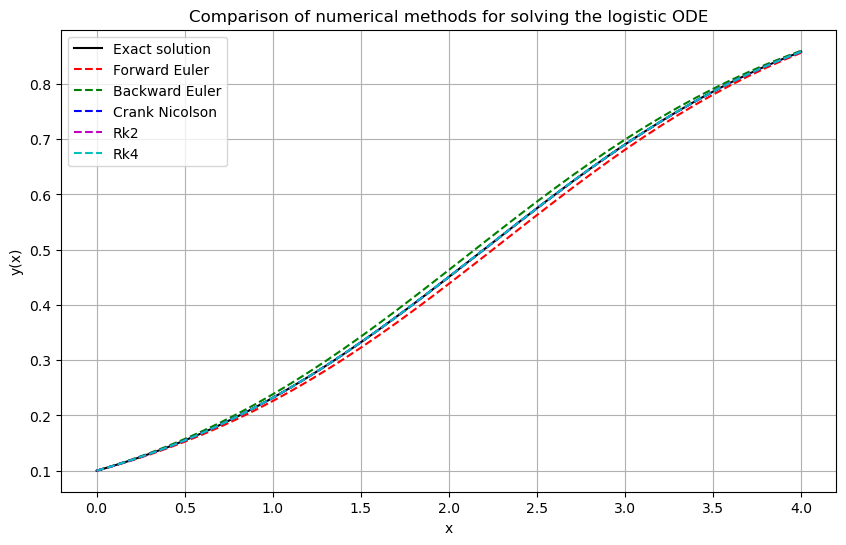

In [14]:
# Plotting the results
x_exact = np.linspace(x0, x_end, 200)
y_exact = exact_solution(x_exact, y0)

plt.figure(figsize=(10, 6))
plt.plot(x_exact, y_exact, "k-", label="Exact solution")

colors = ["r", "g", "b", "m", "c"]
for method, color in zip(methods, colors):
    x, y = solutions[method]
    plt.plot(x, y, "--", label=method.replace("_", " ").title(), color=color)

plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("Comparison of numerical methods for solving the logistic ODE")
plt.legend()
plt.grid()
plt.show()

In the result we can see, Crank-Nicolson, Heun's RK2, and RK4 all closely follow the exact solution, meaning they are very accurate. Forward Euler consistently undershoots the exact solution, making it less reliable. Backward Euler overshoots the exact solution, which also makes it less accurate. This behavior aligns with our expectations.

#### 1.2 Local Truncation error

Each method has a theoretical truncation error per step:
- Forward Euler: $O(h)$
- Backward Euler: $O(h)$
- Crank-Nicolson: $O(h^2)$
- Heun's RK2: $O(h^2)$
- RK4: $O(h^4)$

Since we're plotting on a log-log scale, we expect:
- Forward and backward Euler to have a slope of $1$
- Crank-Nicolson and RK2 to have slopes of $2$
- RK4 to have a slope of $4$

We'll iterate over different values of $h$ from $10^{-3}$ to $10^{-1}$, compute the error for a single step, and plot the results.

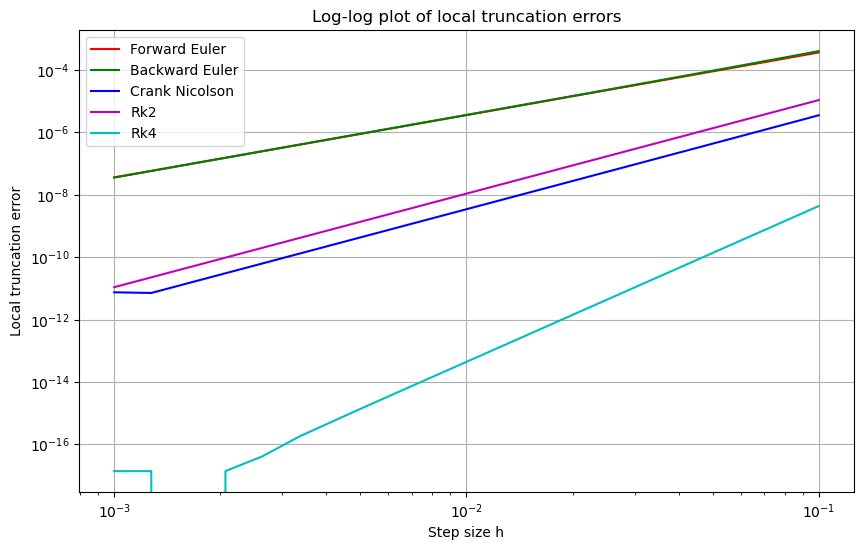

In [15]:
y0 = 0.1
h_values = np.logspace(-3, -1, 20)
errors = {method: [] for method in methods}

for h in h_values:
    y_exact = exact_solution(h, y0)

    errors["forward_euler"].append(np.abs(forward_euler(f, 0, y0, h) - y_exact))
    errors["backward_euler"].append(np.abs(backward_euler(f, df, 0, y0, h) - y_exact))
    errors["crank_nicolson"].append(np.abs(crank_nicolson(f, df, 0, y0, h) - y_exact))
    errors["rk2"].append(np.abs(rk2(f, 0, y0, h) - y_exact))
    errors["rk4"].append(np.abs(rk4(f, 0, y0, h) - y_exact))

plt.figure(figsize=(10, 6))
for method, color in zip(methods, colors):
    plt.loglog(h_values, errors[method], label=method.replace("_", " ").title(), color=color)

plt.xlabel("Step size h")
plt.ylabel("Local truncation error")
plt.title("Log-log plot of local truncation errors")
plt.legend()
plt.grid()
plt.show()

Our results show, that the Forward Euler and backward Euler methods have a slope of $1$. The Crank-Nicholson and Heun's RK2 methods have a slope of $2$. The RK4 method has a steeper slope, around $4$, confirming its fourth-order accuracy. 

As expected, RK4 has the smallest error, followed by Crank-Nicholson and Heun's RK2, and finally Euler methods with the largest error. This means that for the same step size $h$, higher-order methods give more accurate results. For very small $h$, RK4’s error flattens, likely due to floating-point precision limits. A slight dip can be seen in the curve for the RK2 and a more prominent dip in the curve for RK4. This dips may indicate numerical precision limits. These could be due to floating points precision limits. When the step size $h$ becomes very small, the local truncation error should theoretically keep decreasing. However, in practical computations, floating-point arithmetic has finite precision. At very small $h$, the truncation error becomes smaller than machine precision, and round-off errors dominate, leading to artificially increased errors after the dip. These dips could also be due to that RK2 and RK4 involve multiple floating-point operations per step (especially RK4 with four intermediate calculations). When subtracting two nearly equal numbers (like in error computation), rounding errors may accumulate, creating artificial dips before the error starts increasing again.

This result suggest, that for high accuracy, RK4 is the best choice. For a a balance of efficiency and accuracy, Crank-Nicholson or Heun's RK2 might be preferred. Forward and backward Euler are not very accurate, but are simple and sometimes useful for rough approximations.

#### 1.3 Global Truncation Error

Unlike the local truncation error (which only looks at one step), the global truncation error accumulates over multiple steps.

Since we're fixing $x_{max} = 0.2$ and varying the number of steps $N$, the step size is given by:

$h = \frac{x_{max}}{N}$

Thus, as $N$ increases (or equivalently, as $h$ decreases), the global error should scale accordingly:

Global error $\approx Ch^p = C (\frac{x_{max}}{N})^p$, where $p$ is the order of the method.

To implement this we fix $x_{max} = 0.2$ and vary the number of steps $N$. We compute $h = x_{max} / N$ and integrate each method to $x_{max}$. We then compute the absolute error

$\epsilon_{global} = |y_{num}(x_{max} - y_{exact}(x_{max}))$

and plot the error vs. h in a log-log plot.

In [16]:
def integrate(method, f, df, x_max, y0, N):
    h = x_max / N
    x, y = 0,y0

    for i in range(N):
        if method == "forward_euler":
            y = forward_euler(f, x, y, h)
        elif method == "backward_euler":
            y = backward_euler(f, df, x, y, h)
        elif method == "crank_nicolson":
            y = crank_nicolson(f, df, x, y, h)
        elif method == "rk2":
            y = rk2(f, x, y, h)
        elif method == "rk4":
            y = rk4(f, x, y, h)
        x += h
    return y

The integrate function, iterates over a given number of steps to compute $y(x)$ for a given range. Each numerical method is applied depending on user choice.

To compute the global truncation error, we fix $x_max = 0.2$ and vary the number of steps.

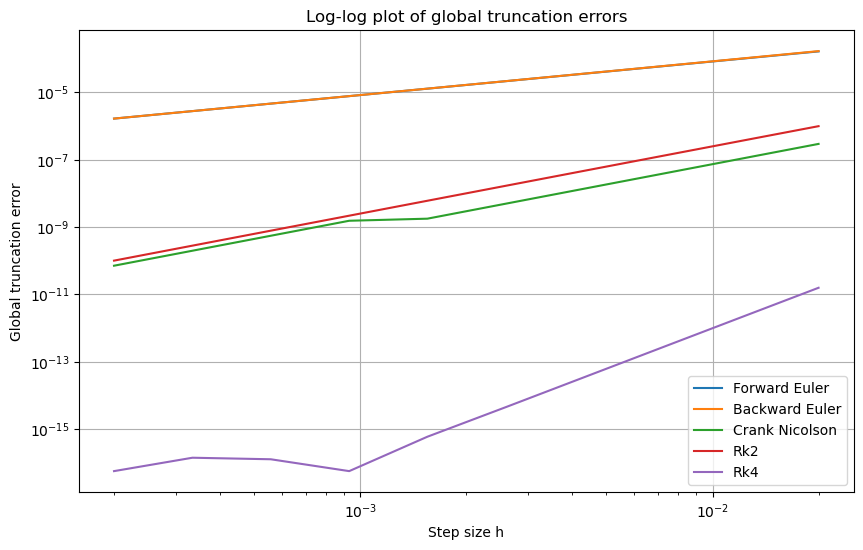

In [17]:
y0 = 0.1
x_max = 0.2
N_values = np.logspace(1, 3, 10, dtype=int)
h_values = x_max / N_values
errors = {method: [] for method in methods}

for N in N_values:
    y_exact = exact_solution(x_max, y0)
    for method in errors:
        y_num = integrate(method, f, df, x_max, y0, N)
        errors[method].append(np.abs(y_num - y_exact))

plt.figure(figsize=(10, 6))
for method, err in errors.items():
    plt.loglog(h_values, err, label=method.replace("_", " ").title())

plt.xlabel("Step size h")
plt.ylabel("Global truncation error")
plt.title("Log-log plot of global truncation errors")
plt.legend()
plt.grid()
plt.show()

In our results the slopes are the same as in our results for the local truncation errors. RK4 has the smallest error, while forward and backward Euler have the largest. The small dips in RK2 and RK4 are mostly likely due to floating-point precision, similiarly to the local truncation errors.

###  2. Solutions of the three-body problem

#### 2.1 Three body problem with RK2

To rewrite the second order ODE given in the sheet: $\ddot{r_i} = -\sum_{j=1}^3 \frac{r_i -r_j}{|r_i -r_j|^3} $ (i = 1,2,3). (Without the arrows for simplicity.
We let $v_i = \dot{r_i}$, therefore the systems equations are :    
(i) $\dot{r_i} = v_i$ \
(ii) $\dot{v_i} =  -\sum_{j=1}^3 \frac{r_i -r_j}{|r_i -r_j|^3}$, this then becomes a vector dependent on the bodies
$\dot{v}= (\frac{dv_i}{dt}) = a_i(r_1,r_2,r_3)$

In [18]:
# Heun's Runge-Kutta 2nd order method
def rk2(f, x, y, h):
    k1 = f(x, y)
    k2 = f(x + h, y + h * k1)
    return y + h / 2 * (k1 + k2)

In [19]:
# Compute the acceleration for a 3-body problem
def acceleration(positions):
    """Compute accelerations for 3-body interaction."""
    n_bodies = 3
    acc = np.zeros_like(positions)
    for i in range(n_bodies):
        for j in range(n_bodies):
            if i != j:
                diff = positions[i] - positions[j]
                dist = np.linalg.norm(diff)
                acc[i] -= diff / dist**3
    return acc

We use the acceleration function to calculate the  gravitational acceleration for each of the three bodies, by looping through all body pairs and compute the differences as a vector. We use Newton’s law of gravitation to calculate their acceleration.

In [20]:
# Compute the derivatives for a 3-body problem
def derivatives(t, state):
    """Compute the time derivative of the state."""
    positions = state[:6].reshape(3, 2)
    velocities = state[6:].reshape(3, 2)
    acc = acceleration(positions)
    return np.concatenate([velocities.flatten(), acc.flatten()])

The derivative function is used for the integrate function. This is required because RK2 (like most numerical solvers) works with first-order differential equations. Our equation is second-order, but numerical solvers require a system of first-order equations, so we define state variables. The first six elements of state correspond to positions. The last six elements correspond to velocities. This transformation allows RK2 to handle the system properly.

In [21]:
# Integrate the 3-body problem using RK2
def integrate(f, y0, t0, t_end, h):
    """Integrate from t0 to t_end using rk2."""
    ts = [t0]
    ys = [y0]
    t = t0
    y = y0.copy()
    while t < t_end:
        y = rk2(f, t, y, h)
        t += h
        ts.append(t)
        ys.append(y)
    return np.array(ts), np.array(ys)

The integrate function performs a numerical integration using RK2. It starts with the initial conditions and uses the rk2 function from the lecture to step forward in time. It stores the state after each step.

In [22]:
# Initial conditions
r1 = np.array([-1.0, 0.0])
r2 = np.array([ 1.0, 0.0])
r3 = np.array([ 0.0, 0.0])
v1 = np.array([ 0.080584,  0.588836])
v2 = np.array([ 0.080584,  0.588836])
v3 = np.array([-0.161168, -1.177672])

# Flatten into single state vector
y0 = np.concatenate([r1, r2, r3, v1, v2, v3])
t0 = 0.0
tperiod = 21.272338
h = 0.00001

# Run the integration
ts, ys = integrate(derivatives, y0, t0, tperiod, h)

We take the initial conditions and flatten them into a single state vector. Positions and velocities are stored in a 1D array so that they can be treated uniformly in the RK2 integration, making the derivatives function simpler. After testing different step sizes, we settled on $h=0.00001$. Smaller step sizes improved accuracy but made computations significantly slower. Conversely, larger step sizes introduced numerical instability, causing the trajectories to deviate from the expected periodic orbits.

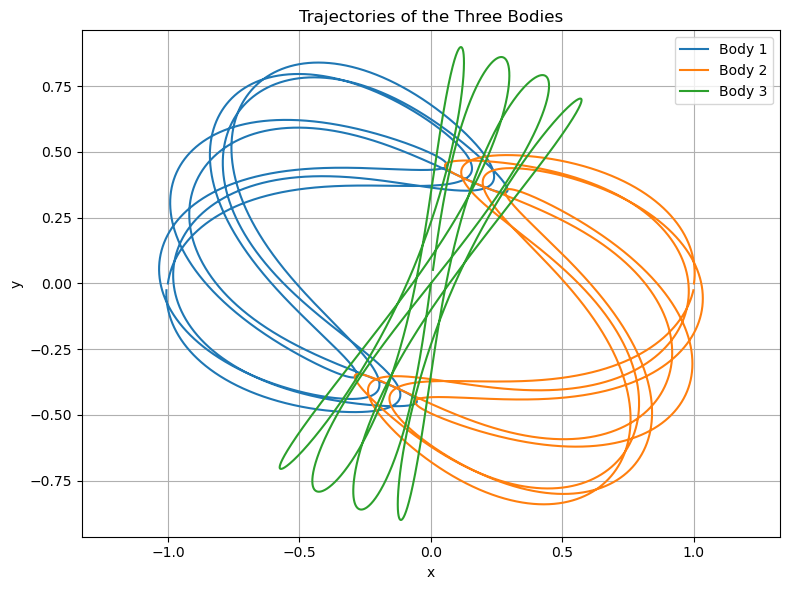

In [23]:
# Extract positions
positions = ys[:, :6].reshape(-1, 3, 2)

# Plot trajectories
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(positions[:, i, 0], positions[:, i, 1], label=f'Body {i+1}')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-10, 10)
plt.ylim(-10,10)
plt.title('Trajectories of the Three Bodies')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

The resulting plot shows the complex periodic orbits for the three bodies. The system is chaotic, meaning small numerical errors can lead to drastically different results over time. The motion is not simple circular orbits, but rather intricate paths due to mutual gravitational interaction. Ideally, after one full period (21.272338 time units), the bodies should return close to their initial positions. 

In [ ]:
# Finding the minimum h for a given accuracy
h = 0.00001
error_threshold = 1e-3
found_h = None

while h > 1e-6:  # Prevent infinite loop in case of numerical issues
    ts, ys = integrate(derivatives, y0, t0, tperiod, h)
    final_positions = ys[-1, :6].reshape(3, 2)
    initial_positions = y0[:6].reshape(3, 2)
    max_error = np.max(np.linalg.norm(final_positions - initial_positions, axis=1))
    
    if max_error < error_threshold:
        found_h = h
        break
    h *= 0.5  # Reduce h for better accuracy

print(f"Minimum h needed for 10^-3 accuracy: {found_h}")


Minimum h needed for 10^-3 accuracy: 2.5e-06


We want to find the smallest step size $h$ that ensures the three-body system returns to its initial positions within $10^{-3}$ accuracy after one full period ($t_{period}=21.272338$). For this we loop over $h$ > 1e-6 to prevent an infinite loop, we stop if $h$ gets too small. We integrate the system with the current $h$, which runs with the RK2 integration from $t_0$ to $t_{period}$. We extract the positions from the solution of the three bodies. We compute the maximum error, by computing the euclidean distance between the final and initial positions for each body. We then take the maximum of these three values as the maximum error. This error is checked with the accuracy of $10^{-3}$, if its smaller we store the $h$ and exit the loop. If the error is too large we decrease $h$ by half and continue the loop until the correct $h$ is found.

Starting with our step size $h = 0.00001$ the minimum $h$ is found to be at 2.5e-6. Computing that took about $20$ which is far too long. However with a larger step size the computation took even longer, so we settled with this.

In [22]:
h = 0.001
error_threshold = 1e-3
found_h = None

while h > 1e-6:  # Prevent infinite loop in case of numerical issues
    ts, ys = integrate(derivatives, y0, t0, tperiod, h)
    final_positions = ys[-1, :6].reshape(3, 2)
    initial_positions = y0[:6].reshape(3, 2)
    max_error = np.max(np.linalg.norm(final_positions - initial_positions, axis=1))
    
    if max_error < error_threshold:
        found_h = h
        break
    h *= 0.5  # Reduce h for better accuracy

print(f"Minimum h needed for 10^-3 accuracy: {found_h}")

Minimum h needed for 10^-3 accuracy: 1.953125e-06


#### 2.2 Three body problem with Gragg-Bulirsch-Stoer method

In [24]:
# Define the correct modified midpoint rule provided by the user
def modified_midpoint_rule(f, x0, y0, h, n):
    """
    Modified mid-point rule for n sub-steps.
    """
    nx = n + 1
    eta = h / n
    x = np.linspace(x0, x0 + h, nx)
    y = np.zeros((len(y0), nx))

    y[:, 0] = y0
    y[:, 1] = y0 + eta * f(x0, y0)
    for i in range(2, nx):
        y[:, i] = y[:, i - 2] + 2 * eta * f(x[i - 1], y[:, i - 1])
    y[:, -1] = 0.5 * (y[:, -1] + y[:, -2] + eta * f(x[-1], y[:, -1]))
    return x, y

In [25]:
# Re-defining the Bulirsch-Stoer step and integrator using this
def gragg_bulirsch_stoer_step(f, x0, y0, h, tol, n_refine_max=8):
    n = 2 * np.arange(1, n_refine_max + 1)
    ny = len(y0)
    tol = np.full(ny, tol) if np.isscalar(tol) else tol

    T = np.zeros((ny, n_refine_max, n_refine_max))
    E = np.zeros((ny, n_refine_max))

    for j in range(n_refine_max):
        _, y = modified_midpoint_rule(f, x0, y0, h, n[j])
        T[:, j, 0] = y[:, -1]

        if j > 0:
            for k in range(0, j):
                num = T[:, j, k] - T[:, j - 1, k]
                den = (n[j] / n[j - k - 1])**2 - 1
                T[:, j, k + 1] = T[:, j, k] + num / den

            E[:, j] = np.abs(T[:, j, j] - T[:, j, j - 1])

            if np.all(E[:, j] < tol):
                return T[:, j, j], True, E[:, j], j + 1

    return T[:, -1, -1], False, E[:, -1], n_refine_max

In [26]:
def gragg_bulirsch_stoer(f, x0, y0, x_end, h_first=0.1, tol=1e-6, n_refine_max=8, max_steps=100000):
    x_vals, y_vals, err_vals = np.array([x0]), np.array([y0]), np.array([np.zeros_like(y0)])
    x, h, num_steps = x0, h_first, 0

    while x < x_end:
        h = min(h, (x_end - x) + np.finfo(float).eps)
        num_steps += 1
        yF, converged, error, nrefine = gragg_bulirsch_stoer_step(f, x, y_vals[-1], h, tol, n_refine_max)

        if converged:
            x = x + h
            x_vals = np.append(x_vals, x)
            y_vals = np.vstack((y_vals, yF))
            err_vals = np.vstack((err_vals, error))
            h *= min(2, np.max(0.9 * (tol / (error + 1e-12))**(1. / (2 * nrefine))))
        else:
            h *= max(0.1, np.min(0.9 * (tol / (error + 1e-12))**(1. / (2 * nrefine))))

        if num_steps > max_steps:
            raise RuntimeError("Maximum number of steps exceeded.")

    return x_vals, y_vals, err_vals

In [27]:
def compute_error(final_positions, initial_positions):
    return np.max(np.linalg.norm(final_positions - initial_positions, axis=1))

The compute_error() function computes the maximum error between the final and initial positions of the bodies at the end of the integration. The final_positions are the positions of the bodies after the integration (i.e., at the end of the period). The initial_positions are the initial positions of the bodies before integration begins. The function computes the difference between the final and initial positions of each body. It gives the vector displacement for each body. It then computes the euclidean distance (norm) between the final and initial positions for each body (i.e., how far each body has moved). The function then returns the largest of these distances. This value represents the maximum error across all three bodies. It indicates how far the bodies' final positions are from their initial positions in the worst case.

In the next part we loop over a list of different tolerances For each tolerance, the Gragg-Bulirsch-Stoer (GBS) method is used to integrate the three-body system. At the end of the integration, the last state is extracted, which contains the positions and velocities of all three bodies. The first 6 values correspond to the positions of the three bodies, which are reshaped into a (3, 2) array (3 bodies, 2 coordinates for each body). The error between the initial and final positions is calculated using the compute_error function, which tells you how far the bodies have moved from their starting positions. We print the tolerance and the corresponding maximum error. If the error is below the threshold (1e-3), it proceeds to store the trajectory and break the loop.

The loop is broken when the maximum error is within the acceptable threshold of $10^{-3}$. If the error is small enough, it means the integration has achieved the desired accuracy. The positions of the three bodies are extracted and stored in a list called trajectories. This is done so that we can plot the trajectories later.

Tolerance: 1e-06, Max error: 0.011706056845306604
Tolerance: 1e-07, Max error: 0.0006787645621320968
Tolerance 1e-07 reached accuracy within 10^-3 after 146 steps


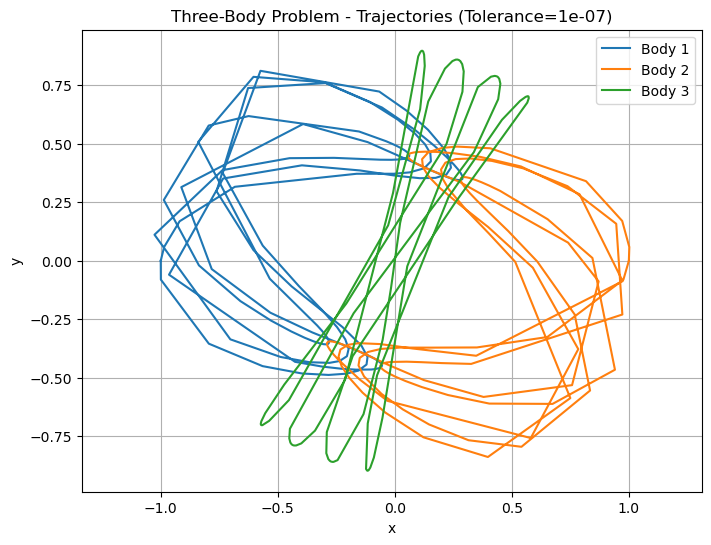

In [28]:
trajectories = []

# Compare accuracy with different tolerances in GBS
tolerances = [1e-6, 1e-7, 1e-8]
for tol in tolerances:
    # Run the Gragg-Bulirsch-Stoer integration
    x_vals, y_vals, err_vals = gragg_bulirsch_stoer(
        derivatives,  # Derivatives function from the first part
        x0=t0,
        y0=y0,
        x_end=tperiod,
        h_first=0.1,
        tol=tol,
        n_refine_max=8
    )

    # Extract final positions of the bodies
    final_positions = y_vals[-1, :6].reshape(3, 2)
    initial_positions = y0[:6].reshape(3, 2)

    # Compute the error in the final positions
    max_error = compute_error(final_positions, initial_positions)
    print(f"Tolerance: {tol}, Max error: {max_error}")

    # If error is within desired threshold, stop and plot
    if max_error < 1e-3:
        print(f"Tolerance {tol} reached accuracy within 10^-3 after {len(x_vals)} steps")

        # Collect the trajectories for plotting
        r1_gbs = y_vals[:, 0:2]
        r2_gbs = y_vals[:, 2:4]
        r3_gbs = y_vals[:, 4:6]
        trajectories.append((r1_gbs, r2_gbs, r3_gbs))
        
        # Break after finding the first tolerance that satisfies the condition
        break

# Plot the trajectories from the first tolerance that meets the accuracy
plt.figure(figsize=(8, 6))
r1_gbs, r2_gbs, r3_gbs = trajectories[0]
plt.plot(r1_gbs[:, 0], r1_gbs[:, 1], label='Body 1')
plt.plot(r2_gbs[:, 0], r2_gbs[:, 1], label='Body 2')
plt.plot(r3_gbs[:, 0], r3_gbs[:, 1], label='Body 3')
plt.title(f"Three-Body Problem - Trajectories (Tolerance={tol})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

The key result from the exercise is to determine how the accuracy of the Gragg-Bulirsch-Stoer integrator depends on the tolerance and how it compares to the Heun RK2 method.

As we reduced the tolerance he error in the final positions decreased significantly. At tolerance 1e-7, the error was small enough to meet the required accuracy threshold of $10^{-3}$. The method took $146$ steps to reach this accuracy. 

The GBS method achieved the desired accuracy with fewer steps compared to the Heun RK2 method (which required a smaller step size in part (a) to achieve similar accuracy). This suggests that the GBS method is more efficient in terms of the number of steps needed to achieve high accuracy, thanks to its adaptive step sizing and higher-order integration.

The GBS method is highly efficient in terms of both accuracy and the number of steps required. It allows us to achieve a high degree of accuracy with fewer steps than methods like RK2.

The tolerance required to meet the accuracy criterion ($10^{-3}$) is crucial for controlling the trade-off between accuracy and computational cost. By adjusting the tolerance, you can balance the precision of the solution with the time/steps needed to compute it.

#### 2.3 Three body problem with scipy.integrate.solve ivp

In [29]:
from scipy.integrate import solve_ivp

In [31]:
t_span = (0, tperiod)

# Use solve_ivp to solve the system with RK45
solution = solve_ivp(
    derivatives,    
    t_span,    
    y0,             
    method='RK45',  
    t_eval=np.linspace(t0, tperiod, 1000),  
    rtol=1e-9,
    atol=1e-9
)

positions = solution.y[:6, :].T.reshape(-1, 3, 2)  # Reshape into 3 bodies, 2 coordinates

The solve_ivp is called with the RK45 method, which is the Runge-Kutta method of order 4(5). The t_eval parameter is a sequence of time points where the solution is computed (in this case, 1000 points between t0 and t_end). The solution from solve_ivp contains the values for the positions and velocities of the bodies over time. The positions are stored in the first 6 elements of solution.y (since there are 3 bodies, each with 2 coordinates). 

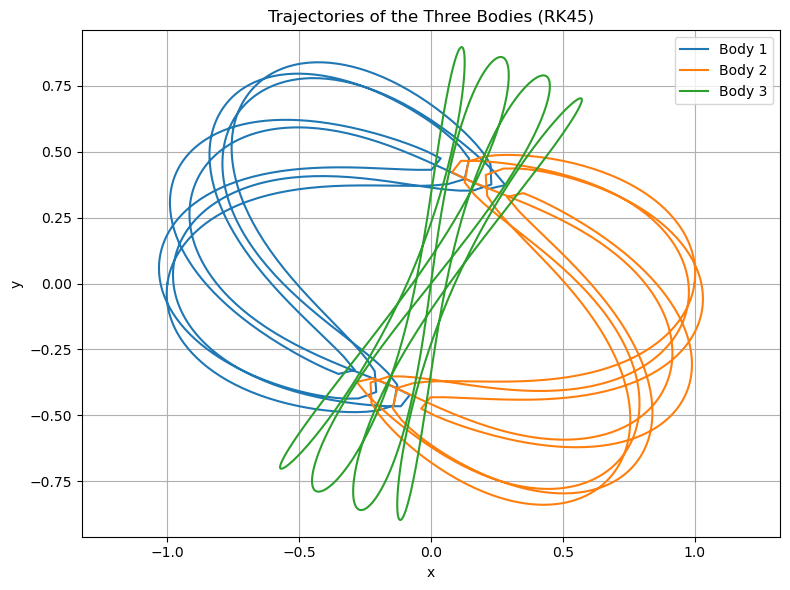

In [32]:
# Plot the trajectories
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(positions[:, i, 0], positions[:, i, 1], label=f'Body {i+1}')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories of the Three Bodies (RK45)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

The plot displays a similiar result as in the first part. 

#### 2.4 Evolution of total energy over time

The total energy of the system at any time $t$ consists of two parts:

Kinetic Energy: 

$E_{kin} = \frac{1}{2} \sum_{i=1}^3 ||\dot{r_i}||^2$

Potential Energy:

$E_{pot} = - \frac{1}{2} \sum_{i=1}^3 \sum_{i=1, i\neq j}^3 \frac{1}{||r_i - r_j||}$

The total energy at time $t$ is then:

$E(t)= E_{kin} + E_{pot}$

In [ ]:
def compute_energy(positions, velocities):
    # Compute kinetic energy (1/2 * v^2 for each body)
    kinetic_energy = 0.5 * np.sum(np.linalg.norm(velocities, axis=2)**2, axis=1)

    # Compute potential energy
    potential_energy = np.zeros(positions.shape[0])
    for i in range(3):
        for j in range(i + 1, 3):  # Avoid double counting pairs
            distance = np.linalg.norm(positions[:, i, :] - positions[:, j, :], axis=1)
            potential_energy -= 1.0 / distance

    # Total energy
    return kinetic_energy + potential_energy

In the function compute_energy() we calculate the total energy of the three body system at each time step. The total energy consists of kinetic and potential energy. We calculate the energy with the given formula.

In [36]:
# Extract positions and velocities from previously computed RK2, GBS, and RK45 results
positions_rk2 = ys[:, :6].reshape(-1, 3, 2)  # From Heun's RK2
velocities_rk2 = ys[:, 6:].reshape(-1, 3, 2)

positions_gbs = y_vals[:, :6].reshape(-1, 3, 2)  # From GBS
velocities_gbs = y_vals[:, 6:].reshape(-1, 3, 2)

positions_rk45 = solution.y[:6].T.reshape(-1, 3, 2)  # From solve_ivp (RK45)
velocities_rk45 = solution.y[6:].T.reshape(-1, 3, 2)

# Compute energy evolution over time
energy_rk2 = compute_energy(positions_rk2, velocities_rk2)
energy_gbs = compute_energy(positions_gbs, velocities_gbs)
energy_rk45 = compute_energy(positions_rk45, velocities_rk45)

# Create time arrays (assuming same step size as integration)
time_rk2 = np.linspace(t0, tperiod * 3, len(energy_rk2))  # 3 periods
time_gbs = np.linspace(t0, tperiod * 3, len(energy_gbs))
time_rk45 = np.linspace(t0, tperiod * 3, len(energy_rk45))

Here we extract the positions and velocities at each time step, for each method. Then we run our compute_energy() function to compute the total energy of the system for each method.

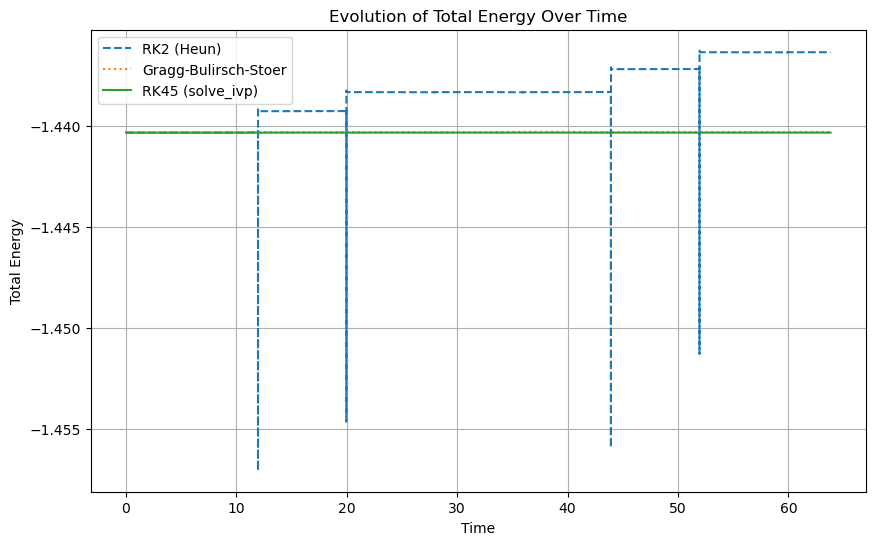

In [39]:
# Plot the energy evolution for all methods
plt.figure(figsize=(10, 6))
plt.plot(time_rk2, energy_rk2, label="RK2 (Heun)", linestyle="dashed")
plt.plot(time_gbs, energy_gbs, label="Gragg-Bulirsch-Stoer", linestyle="dotted")
plt.plot(time_rk45, energy_rk45, label="RK45 (solve_ivp)", linestyle="solid")

plt.xlabel("Time")
plt.ylabel("Total Energy")
plt.title("Evolution of Total Energy Over Time")
plt.legend()
plt.grid(True)
plt.show()

The result shows us, that the RK2 method, has large fluctation in energy. It shows large jumps in energy, meaning it's not energy-conserving. This is likely due to numerical instability or accumulation of error over time. RK2 is not a great method for long-term simulations of the three-body problem.

The GBS appears much more stable. This method is known for adaptive step-size control, which helps maintain energy conservation.

Similiar to the GBS methor, the RK45 method looks also very stable, with almost no deviation. RK45 (adaptive Runge-Kutta) is not symplectic, but it still does a good job for moderate time spans. This suggests RK45 is a reliable method for this problem.